In [49]:
from fxbsm import *
from math import sqrt
import QuantLib as ql
import numpy as np
import pandas as pd
import scipy.interpolate as spi
import matplotlib.pyplot as plt

In [36]:
def vol_from_strike(S, T, rd, rf, strike, quotes, premium_included=1, forward_delta=1, tol=0.00001, maxiter=100):
    _, pivot_deltas, pivot_vols = market_smile(S, T, rd, rf, quotes, premium_included, forward_delta)
    pivot_deltas = -np.array(pivot_deltas)
    pivot_vols = np.array(pivot_vols)
    din = spi.splrep(pivot_deltas, pivot_vols, k=4)
    sigma_est = np.ones(len(strike)) * quotes[0] / 100
    for i in range(maxiter):
        delta = -bsm_delta(S, strike, T, rd, rf, sigma_est, 1)
        sigma_prev = sigma_est
        sigma_est = spi.splev(delta, din)
        if np.allclose(sigma_est, sigma_prev, tol):
            break
    return sigma_est

def pdf_from_smile(S, T, rd, rf, quotes, strike_grid, premium_included=1, forward_delta=1):
    vol_grid = vol_from_strike(S, T, rd, rf, strike_grid, quotes,
                            premium_included, forward_delta, tol=0.00001, maxiter=100)
    call_prices = bsm_value(S, strike_grid, T, rd, rf, vol_grid, 0)
    pdf = (call_prices[2:] - 2 * call_prices[1:-1] + call_prices[:-2])
    pdf = pdf / pdf.sum()
    return strike_grid[1:-1], pdf

def implied_moments(grid, pdf):
    mean = pdf.dot(grid)
    var = pdf.dot((grid - mean)**2)
    skew = pdf.dot((grid - mean)**3) / var**(3/2)
    kurt = pdf.dot((grid - mean)**4) / var**2
    return mean, var, skew, kurt

In [3]:
T=3
rf = 0.043096
S = 18.225
sw = 19985 / 10000
rd = implied_domestic_depo(S, sw, T, rf)
quotes = [15.937, 2.235, 0.612, 4.695, 1.665]
flat_quote = [quotes[0], 0, 0, 0, 0]

-0.012699420042439399 0.15937014236851238 -1.6670713640826016e-06 3.0000010531623125


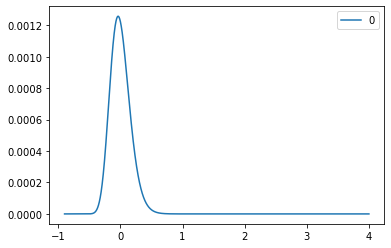

In [4]:
strike_grid = np.linspace(0.1, 5, 10001)
idx, pdf = pdf_from_smile(1, 1, 0, 0, flat_quote, strike_grid, premium_included=0, forward_delta=0)
forward = 1
pd.DataFrame(index = (idx / forward) - 1, data = pdf).plot()
mean, var, skew, kurt = implied_moments(np.log(idx/forward), pdf)
print(mean, sqrt(var), skew, kurt)

-0.03961153560944191 0.15944430247767724 0.3697547990807502 3.674165629667481


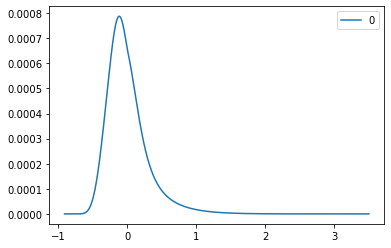

In [5]:
strike_grid = np.linspace(0.1, 5, 10001) * S
idx, pdf = pdf_from_smile(S, T, rd, rf, quotes, strike_grid, premium_included=1, forward_delta=1)
forward = S * exp((rd - rf) * T)
pd.DataFrame(index = (idx / forward) - 1, data = pdf).plot()
mean, var, skew, kurt = implied_moments(np.log(idx/forward), pdf)
print(mean, sqrt(var) / sqrt(T), skew, kurt)

In [7]:
filename = 'USDZAR.csv'
data = pd.read_csv(filename, index_col=0, parse_dates=True).sort_index()
data.head()

,USDZAR Curncy,ZAR1W Curncy,USDZARV1W Curncy,USDZAR25R1W Curncy,USDZAR25B1W Curncy,USDZAR10R1W Curncy,USDZAR10B1W Curncy,USOSFR1Z Curncy
Dates,,,,,,,,
2010-01-08,7.3539,101,18.010,3.0125,0.630,5.2500,1.870,0.1674
2010-01-15,7.3986,101,17.555,3.0225,0.660,5.0675,1.865,0.1774
2010-01-22,7.6359,103,17.980,2.8525,0.600,4.9200,1.755,0.1789
2010-01-29,7.6263,105,16.270,2.7350,0.630,4.7025,1.785,0.1734
2010-02-05,7.7872,115,17.580,2.8950,0.665,4.9325,1.805,0.1754


In [43]:
returns = ((data['USDZAR Curncy'] + data['ZAR1W Curncy'] / 10000) / data['USDZAR Curncy'].shift(1) - 1)
print(returns.mean(), returns.std(), returns.skew(), returns.kurtosis()+3)

0.0025237647439509663 0.021547812350454488 0.5351895527698719 4.18978930018425


In [47]:
T = 7 / 365
grid = np.linspace(0.8, 1.2, 801)
agg = np.array([8]*799)
moments = pd.DataFrame(index = data.index, columns = ['mean', 'var', 'skew', 'kurt'])
for d in data.index:
    rf = data.loc[d, 'USOSFR1Z Curncy'] / 100
    S = data.loc[d, 'USDZAR Curncy']
    sw = data.loc[d, 'ZAR1W Curncy'] / 10000
    rd = implied_domestic_depo(S, sw, T, rf)
    quotes = list(data.loc[d, ['USDZARV1W Curncy',
    'USDZAR25R1W Curncy', 'USDZAR25B1W Curncy', 'USDZAR10R1W Curncy',
    'USDZAR10B1W Curncy']])
    forward = S + sw
    strike_grid = grid * forward
    _, pdf = pdf_from_smile(S, T, rd, rf, quotes, strike_grid, premium_included=1, forward_delta=0)
    agg = np.vstack((agg, pdf))
    mean, var, skew, kurt = implied_moments(np.log(strike_grid/forward)[1:-1], pdf)
    moments.loc[d, moments.columns] = [mean, var, skew, kurt]

    


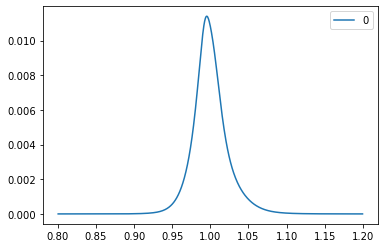

In [39]:
agg = agg[1:]
average_pdf = agg.mean(axis=0)
pd.DataFrame(index=grid[1:-1], data=average_pdf).plot()


In [41]:
implied_moments(grid[1:-1]-1, average_pdf)

(-3.558366910193913e-06,
 0.0005357143123821274,
 0.6182357843374117,
 5.705886048880715)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fde5ae66e20>,
      dtype=object)

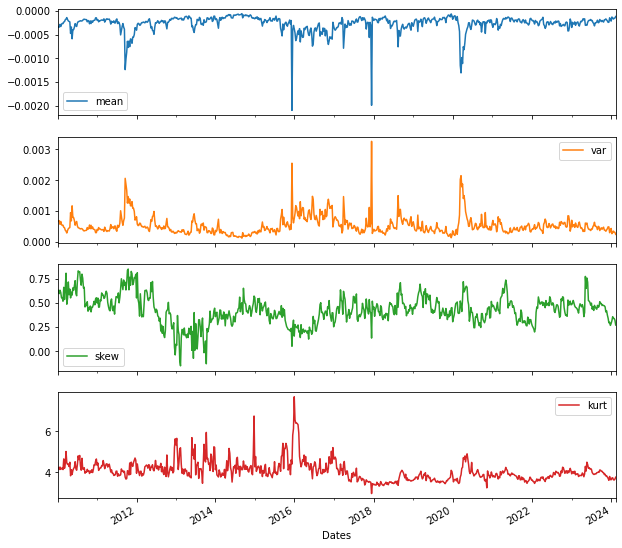

In [48]:
moments.plot(subplots=True, figsize=(10, 10))

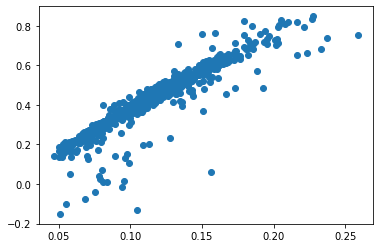

In [53]:
plt.scatter(data['USDZAR25R1W Curncy']/data['USDZARV1W Curncy'], moments['skew'])